# Densely Connected Convolutional Networks

## Overview

## Data

In [24]:
%matplotlib inline
from keras.datasets import cifar100
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

CIFAR100

In [2]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

168960000/169001437 [============================>.] - ETA: 0s

In [12]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [13]:
x_test.shape, y_test.shape

((10000, 32, 32, 3), (10000, 1))

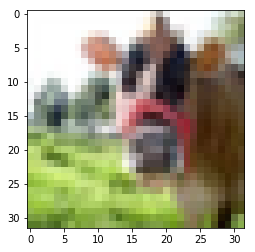

In [23]:
plt.imshow(x_train[0])

### Data augmentation and preprocessing

* Standard data augmentation scheme (mirroring/ shifting)
* Normalize data using channel means and standard deviations

In [36]:
def get_batches(x, y, batch_size=64):
    gen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True,
                             horizontal_flip=True)
    gen.fit(x)
    return gen.flow(x, y, batch_size=batch_size, shuffle=True)

In [88]:
img = get_batches(x_train, y_train).next()[0][0]
# plt.imshow(img)

In [85]:
img_shape = img.shape; img_shape

(32, 32, 3)

## Model

In [111]:
from keras.layers import BatchNormalization, Conv2D, Dense, Input
from keras.layers import GlobalAveragePooling2D, AveragePooling2D, Activation, concatenate
from keras.models import Model
from keras_tqdm import TQDMNotebookCallback
from keras.optimizers import SGD
from keras.callbacks import TensorBoard, ModelCheckpoint

### Components

Conv Block (Composite funciton):

In [92]:
def conv_block(x, filters, kernel_size=3, bottleneck=False):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = bottleneck_layer(x, filters) if bottleneck else x
    x = Conv2D(filters, kernel_size, padding='same')(x)
    # dropout?
    return x

Bottleneck Layer (B):
* Used to reduce the dimensionality of inputs
* Reduce dimensionality of filters by using a 1x1 conv with smaller # of filters
* Paper allows 1x1 conv to produce 4k feature-maps (filters*4)

In [96]:
def bottleneck_layer(x, filters):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters*4, kernel_size=1)(x)
    return x

Dense Block:
* growth-rate (k)
* concatenate 

In [79]:
def dense_block(x, n_layers=4, growth_rate=12, bottleneck=False):
    for layer in range(n_layers):
        h = conv_block(x, growth_rate, bottleneck=bottleneck)
        x = concatenate([x, h])
    return x

Transistion Layer
* pooling
* optional compression (C): 1.0 = no compression

In [98]:
def transistion_layer(x, compression=1.0):
    filters = int(x.get_shape().as_list()[-1] * compression)
    x = BatchNormalization()(x)
    x = Conv2D(filters, 1)(x)
    x = AveragePooling2D((2,2), strides=(2,2))(x)
    return x

### Network Architecture

Growth rate (k):
* each Hl produces k feature-maps
* lth layer has k0 + k*(l-1) input feature-maps

Densenet used in experiments:
* conv block with 16 output channels before 1st dense block
* 3 dense blocks with equal number of layers

In [101]:
def create_network(n_classes, inp, n_blocks=3, n_layers=4, bottleneck=False, compression=1.0): 
    x = Conv2D(16, 3, padding='same')(inp)
    # grow / change n_layers
    x = dense_block(x, n_layers, growth_rate, bottleneck=bottleneck)
    x = transistion_layer(x, compression=compression)
    x = dense_block(x, n_layers, growth_rate, bottleneck=bottleneck)
    x = transistion_layer(x, compression=compression)
    x = dense_block(x, n_layers, growth_rate, bottleneck=bottleneck)
    x = GlobalAveragePooling2D()(x)
    out = Dense(n_classes, activation='softmax')(x)
    return out

### Train

In [103]:
inp = Input(shape=img_shape)

In [104]:
x = create_network(100, inp, bottleneck=True)

In [105]:
model = Model(inp, x)

In [106]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_42 (Conv2D)               (None, 32, 32, 16)    448         input_2[0][0]                    
____________________________________________________________________________________________________
batch_normalization_40 (BatchNor (None, 32, 32, 16)    64          conv2d_42[0][0]                  
____________________________________________________________________________________________________
activation_37 (Activation)       (None, 32, 32, 16)    0           batch_normalization_40[0][0]     
___________________________________________________________________________________________

In [109]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=SGD(0.1, 0.9, nesterov=True),
              metrics=['accuracy'])

In [124]:
parms = {'verbose': 2,
         'callbacks': [TQDMNotebookCallback(), TensorBoard(), ModelCheckpoint('./models')]}

In [125]:
train_gen = get_batches(x_train, y_train)
test_gen = get_batches(x_test, y_test)

In [126]:
model.fit_generator(train_gen,
                    steps_per_epoch=x_train.shape[0]//64,
                    epochs=150,
                    validation_data=test_gen,
                    validation_steps=x_test.shape[0]//64,
                    **parms)

HBox(children=(IntProgress(value=0, description='Training: ', max=150), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0: ', max=781), HTML(value='')))

Epoch 1/150
49s - loss: 3.7037 - acc: 0.1366 - val_loss: 4.1355 - val_acc: 0.1436


HBox(children=(IntProgress(value=0, description='Epoch 1: ', max=781), HTML(value='')))

Epoch 2/150
47s - loss: 3.0460 - acc: 0.2444 - val_loss: 3.6251 - val_acc: 0.1956


HBox(children=(IntProgress(value=0, description='Epoch 2: ', max=781), HTML(value='')))

Epoch 3/150
47s - loss: 2.7232 - acc: 0.3062 - val_loss: 3.2168 - val_acc: 0.2406


HBox(children=(IntProgress(value=0, description='Epoch 3: ', max=781), HTML(value='')))

Epoch 4/150
47s - loss: 2.5207 - acc: 0.3440 - val_loss: 2.7892 - val_acc: 0.3123


HBox(children=(IntProgress(value=0, description='Epoch 4: ', max=781), HTML(value='')))

Epoch 5/150
47s - loss: 2.3862 - acc: 0.3742 - val_loss: 2.9140 - val_acc: 0.2959


HBox(children=(IntProgress(value=0, description='Epoch 5: ', max=781), HTML(value='')))

Epoch 6/150
47s - loss: 2.2976 - acc: 0.3952 - val_loss: 2.6427 - val_acc: 0.3386


HBox(children=(IntProgress(value=0, description='Epoch 6: ', max=781), HTML(value='')))

Epoch 7/150
47s - loss: 2.2273 - acc: 0.4091 - val_loss: 2.4555 - val_acc: 0.3718


HBox(children=(IntProgress(value=0, description='Epoch 7: ', max=781), HTML(value='')))

Epoch 8/150
47s - loss: 2.1667 - acc: 0.4228 - val_loss: 2.4400 - val_acc: 0.3848


HBox(children=(IntProgress(value=0, description='Epoch 8: ', max=781), HTML(value='')))

Epoch 9/150
47s - loss: 2.1203 - acc: 0.4335 - val_loss: 2.3903 - val_acc: 0.3990


HBox(children=(IntProgress(value=0, description='Epoch 9: ', max=781), HTML(value='')))

Epoch 10/150
47s - loss: 2.0733 - acc: 0.4400 - val_loss: 2.5077 - val_acc: 0.3656


HBox(children=(IntProgress(value=0, description='Epoch 10: ', max=781), HTML(value='')))

Epoch 11/150
47s - loss: 2.0253 - acc: 0.4537 - val_loss: 2.6461 - val_acc: 0.3497


HBox(children=(IntProgress(value=0, description='Epoch 11: ', max=781), HTML(value='')))

Epoch 12/150
47s - loss: 1.9954 - acc: 0.4619 - val_loss: 2.4450 - val_acc: 0.3872


HBox(children=(IntProgress(value=0, description='Epoch 12: ', max=781), HTML(value='')))

Epoch 13/150
48s - loss: 1.9715 - acc: 0.4669 - val_loss: 2.2762 - val_acc: 0.4131


HBox(children=(IntProgress(value=0, description='Epoch 13: ', max=781), HTML(value='')))

Epoch 14/150
47s - loss: 1.9374 - acc: 0.4760 - val_loss: 2.5081 - val_acc: 0.3787


HBox(children=(IntProgress(value=0, description='Epoch 14: ', max=781), HTML(value='')))

Epoch 15/150
47s - loss: 1.9109 - acc: 0.4811 - val_loss: 2.0454 - val_acc: 0.4669


HBox(children=(IntProgress(value=0, description='Epoch 15: ', max=781), HTML(value='')))

Epoch 16/150
47s - loss: 1.8879 - acc: 0.4854 - val_loss: 2.0592 - val_acc: 0.4727


HBox(children=(IntProgress(value=0, description='Epoch 16: ', max=781), HTML(value='')))

Epoch 17/150
47s - loss: 1.8744 - acc: 0.4898 - val_loss: 2.2519 - val_acc: 0.4299


HBox(children=(IntProgress(value=0, description='Epoch 17: ', max=781), HTML(value='')))

Epoch 18/150
47s - loss: 1.8477 - acc: 0.4959 - val_loss: 2.1924 - val_acc: 0.4410


HBox(children=(IntProgress(value=0, description='Epoch 18: ', max=781), HTML(value='')))

Epoch 19/150
47s - loss: 1.8422 - acc: 0.4961 - val_loss: 2.0161 - val_acc: 0.4660


HBox(children=(IntProgress(value=0, description='Epoch 19: ', max=781), HTML(value='')))

Epoch 20/150
47s - loss: 1.8219 - acc: 0.5010 - val_loss: 2.0870 - val_acc: 0.4703


HBox(children=(IntProgress(value=0, description='Epoch 20: ', max=781), HTML(value='')))

Epoch 21/150
47s - loss: 1.8067 - acc: 0.5025 - val_loss: 2.0311 - val_acc: 0.4626


HBox(children=(IntProgress(value=0, description='Epoch 21: ', max=781), HTML(value='')))

Epoch 22/150
47s - loss: 1.7907 - acc: 0.5083 - val_loss: 2.1095 - val_acc: 0.4527


HBox(children=(IntProgress(value=0, description='Epoch 22: ', max=781), HTML(value='')))

Epoch 23/150
47s - loss: 1.7741 - acc: 0.5154 - val_loss: 2.2242 - val_acc: 0.4544


HBox(children=(IntProgress(value=0, description='Epoch 23: ', max=781), HTML(value='')))

Epoch 24/150
47s - loss: 1.7519 - acc: 0.5204 - val_loss: 2.0733 - val_acc: 0.4672


HBox(children=(IntProgress(value=0, description='Epoch 24: ', max=781), HTML(value='')))

Epoch 25/150
47s - loss: 1.7479 - acc: 0.5178 - val_loss: 2.1860 - val_acc: 0.4442


HBox(children=(IntProgress(value=0, description='Epoch 25: ', max=781), HTML(value='')))

Epoch 26/150
47s - loss: 1.7318 - acc: 0.5228 - val_loss: 2.2031 - val_acc: 0.4448


HBox(children=(IntProgress(value=0, description='Epoch 26: ', max=781), HTML(value='')))

Epoch 27/150
48s - loss: 1.7353 - acc: 0.5235 - val_loss: 2.0646 - val_acc: 0.4700


HBox(children=(IntProgress(value=0, description='Epoch 27: ', max=781), HTML(value='')))

Epoch 28/150
47s - loss: 1.7142 - acc: 0.5281 - val_loss: 2.1252 - val_acc: 0.4518


HBox(children=(IntProgress(value=0, description='Epoch 28: ', max=781), HTML(value='')))

Epoch 29/150
47s - loss: 1.7034 - acc: 0.5317 - val_loss: 2.0643 - val_acc: 0.4810


HBox(children=(IntProgress(value=0, description='Epoch 29: ', max=781), HTML(value='')))

Epoch 30/150
47s - loss: 1.6996 - acc: 0.5299 - val_loss: 1.9808 - val_acc: 0.4797


HBox(children=(IntProgress(value=0, description='Epoch 30: ', max=781), HTML(value='')))

Epoch 31/150
47s - loss: 1.6840 - acc: 0.5354 - val_loss: 2.1052 - val_acc: 0.4654


HBox(children=(IntProgress(value=0, description='Epoch 31: ', max=781), HTML(value='')))

Epoch 32/150
47s - loss: 1.6772 - acc: 0.5379 - val_loss: 1.9677 - val_acc: 0.4881


HBox(children=(IntProgress(value=0, description='Epoch 32: ', max=781), HTML(value='')))

Epoch 33/150
47s - loss: 1.6716 - acc: 0.5375 - val_loss: 2.0220 - val_acc: 0.4876


HBox(children=(IntProgress(value=0, description='Epoch 33: ', max=781), HTML(value='')))

Epoch 34/150
47s - loss: 1.6619 - acc: 0.5421 - val_loss: 1.9490 - val_acc: 0.4882


HBox(children=(IntProgress(value=0, description='Epoch 34: ', max=781), HTML(value='')))

Epoch 35/150
47s - loss: 1.6649 - acc: 0.5395 - val_loss: 1.9850 - val_acc: 0.4835


HBox(children=(IntProgress(value=0, description='Epoch 35: ', max=781), HTML(value='')))

Epoch 36/150
47s - loss: 1.6432 - acc: 0.5459 - val_loss: 2.0004 - val_acc: 0.4866


HBox(children=(IntProgress(value=0, description='Epoch 36: ', max=781), HTML(value='')))

Epoch 37/150
47s - loss: 1.6392 - acc: 0.5467 - val_loss: 1.9846 - val_acc: 0.4938


HBox(children=(IntProgress(value=0, description='Epoch 37: ', max=781), HTML(value='')))

Epoch 38/150
47s - loss: 1.6279 - acc: 0.5477 - val_loss: 2.0551 - val_acc: 0.4764


HBox(children=(IntProgress(value=0, description='Epoch 38: ', max=781), HTML(value='')))

Epoch 39/150
47s - loss: 1.6262 - acc: 0.5470 - val_loss: 1.9899 - val_acc: 0.4867


HBox(children=(IntProgress(value=0, description='Epoch 39: ', max=781), HTML(value='')))

Epoch 40/150
47s - loss: 1.6234 - acc: 0.5482 - val_loss: 1.8751 - val_acc: 0.5089


HBox(children=(IntProgress(value=0, description='Epoch 40: ', max=781), HTML(value='')))

Epoch 41/150
47s - loss: 1.6202 - acc: 0.5504 - val_loss: 1.9404 - val_acc: 0.4919


HBox(children=(IntProgress(value=0, description='Epoch 41: ', max=781), HTML(value='')))

Epoch 42/150
47s - loss: 1.6088 - acc: 0.5524 - val_loss: 1.8954 - val_acc: 0.5052


HBox(children=(IntProgress(value=0, description='Epoch 42: ', max=781), HTML(value='')))

Epoch 43/150
47s - loss: 1.6072 - acc: 0.5517 - val_loss: 2.0482 - val_acc: 0.4798


HBox(children=(IntProgress(value=0, description='Epoch 43: ', max=781), HTML(value='')))

Epoch 44/150
47s - loss: 1.5902 - acc: 0.5549 - val_loss: 2.0019 - val_acc: 0.4817


HBox(children=(IntProgress(value=0, description='Epoch 44: ', max=781), HTML(value='')))

Epoch 45/150
47s - loss: 1.5889 - acc: 0.5587 - val_loss: 1.9837 - val_acc: 0.4791


HBox(children=(IntProgress(value=0, description='Epoch 45: ', max=781), HTML(value='')))

Epoch 46/150
47s - loss: 1.5778 - acc: 0.5607 - val_loss: 1.9933 - val_acc: 0.4841


HBox(children=(IntProgress(value=0, description='Epoch 46: ', max=781), HTML(value='')))

Epoch 47/150
47s - loss: 1.5771 - acc: 0.5611 - val_loss: 2.1593 - val_acc: 0.4584


HBox(children=(IntProgress(value=0, description='Epoch 47: ', max=781), HTML(value='')))

Epoch 48/150
47s - loss: 1.5711 - acc: 0.5638 - val_loss: 2.1828 - val_acc: 0.4669


HBox(children=(IntProgress(value=0, description='Epoch 48: ', max=781), HTML(value='')))

Epoch 49/150
47s - loss: 1.5632 - acc: 0.5633 - val_loss: 2.0181 - val_acc: 0.4838


HBox(children=(IntProgress(value=0, description='Epoch 49: ', max=781), HTML(value='')))

Epoch 50/150
47s - loss: 1.5607 - acc: 0.5647 - val_loss: 2.0495 - val_acc: 0.4772


HBox(children=(IntProgress(value=0, description='Epoch 50: ', max=781), HTML(value='')))

Epoch 51/150
47s - loss: 1.5573 - acc: 0.5651 - val_loss: 1.8721 - val_acc: 0.5158


HBox(children=(IntProgress(value=0, description='Epoch 51: ', max=781), HTML(value='')))

Epoch 52/150
47s - loss: 1.5595 - acc: 0.5632 - val_loss: 2.0326 - val_acc: 0.4851


HBox(children=(IntProgress(value=0, description='Epoch 52: ', max=781), HTML(value='')))

Epoch 53/150
47s - loss: 1.5397 - acc: 0.5705 - val_loss: 2.2082 - val_acc: 0.4547


HBox(children=(IntProgress(value=0, description='Epoch 53: ', max=781), HTML(value='')))

Epoch 54/150
47s - loss: 1.5438 - acc: 0.5680 - val_loss: 2.0631 - val_acc: 0.4912


HBox(children=(IntProgress(value=0, description='Epoch 54: ', max=781), HTML(value='')))

Epoch 55/150
47s - loss: 1.5418 - acc: 0.5693 - val_loss: 2.0158 - val_acc: 0.4902


HBox(children=(IntProgress(value=0, description='Epoch 55: ', max=781), HTML(value='')))

Epoch 56/150
47s - loss: 1.5445 - acc: 0.5719 - val_loss: 1.9687 - val_acc: 0.4877


HBox(children=(IntProgress(value=0, description='Epoch 56: ', max=781), HTML(value='')))

Epoch 57/150
47s - loss: 1.5370 - acc: 0.5715 - val_loss: 1.9045 - val_acc: 0.5097


HBox(children=(IntProgress(value=0, description='Epoch 57: ', max=781), HTML(value='')))

Epoch 58/150
47s - loss: 1.5269 - acc: 0.5725 - val_loss: 1.9609 - val_acc: 0.4927


HBox(children=(IntProgress(value=0, description='Epoch 58: ', max=781), HTML(value='')))

Epoch 59/150
47s - loss: 1.5340 - acc: 0.5711 - val_loss: 1.9275 - val_acc: 0.5033


HBox(children=(IntProgress(value=0, description='Epoch 59: ', max=781), HTML(value='')))

Epoch 60/150
47s - loss: 1.5233 - acc: 0.5741 - val_loss: 1.9754 - val_acc: 0.4896


HBox(children=(IntProgress(value=0, description='Epoch 60: ', max=781), HTML(value='')))

Epoch 61/150
47s - loss: 1.5120 - acc: 0.5781 - val_loss: 1.9245 - val_acc: 0.4882


HBox(children=(IntProgress(value=0, description='Epoch 61: ', max=781), HTML(value='')))

Epoch 62/150
47s - loss: 1.5132 - acc: 0.5793 - val_loss: 2.0134 - val_acc: 0.4731


HBox(children=(IntProgress(value=0, description='Epoch 62: ', max=781), HTML(value='')))

Epoch 63/150
48s - loss: 1.5051 - acc: 0.5767 - val_loss: 2.0779 - val_acc: 0.4928


HBox(children=(IntProgress(value=0, description='Epoch 63: ', max=781), HTML(value='')))

Epoch 64/150
47s - loss: 1.4994 - acc: 0.5814 - val_loss: 1.9743 - val_acc: 0.4986


HBox(children=(IntProgress(value=0, description='Epoch 64: ', max=781), HTML(value='')))

Epoch 65/150
47s - loss: 1.5058 - acc: 0.5776 - val_loss: 1.9379 - val_acc: 0.5134


HBox(children=(IntProgress(value=0, description='Epoch 65: ', max=781), HTML(value='')))

Epoch 66/150
47s - loss: 1.5060 - acc: 0.5789 - val_loss: 1.9519 - val_acc: 0.5013


HBox(children=(IntProgress(value=0, description='Epoch 66: ', max=781), HTML(value='')))

Epoch 67/150
47s - loss: 1.5076 - acc: 0.5780 - val_loss: 2.0755 - val_acc: 0.4772


HBox(children=(IntProgress(value=0, description='Epoch 67: ', max=781), HTML(value='')))

Epoch 68/150
47s - loss: 1.4909 - acc: 0.5829 - val_loss: 1.9260 - val_acc: 0.5056


HBox(children=(IntProgress(value=0, description='Epoch 68: ', max=781), HTML(value='')))

Epoch 69/150
47s - loss: 1.4937 - acc: 0.5798 - val_loss: 1.9397 - val_acc: 0.5077


HBox(children=(IntProgress(value=0, description='Epoch 69: ', max=781), HTML(value='')))

Epoch 70/150
47s - loss: 1.4869 - acc: 0.5844 - val_loss: 1.9287 - val_acc: 0.5015


HBox(children=(IntProgress(value=0, description='Epoch 70: ', max=781), HTML(value='')))

Epoch 71/150
47s - loss: 1.4812 - acc: 0.5861 - val_loss: 2.0127 - val_acc: 0.4937


HBox(children=(IntProgress(value=0, description='Epoch 71: ', max=781), HTML(value='')))

Epoch 72/150
47s - loss: 1.4707 - acc: 0.5858 - val_loss: 2.2192 - val_acc: 0.4854


HBox(children=(IntProgress(value=0, description='Epoch 72: ', max=781), HTML(value='')))

Epoch 73/150
47s - loss: 1.4868 - acc: 0.5861 - val_loss: 2.1147 - val_acc: 0.4904


HBox(children=(IntProgress(value=0, description='Epoch 73: ', max=781), HTML(value='')))

Epoch 74/150
46s - loss: 1.4751 - acc: 0.5849 - val_loss: 1.9972 - val_acc: 0.4932


HBox(children=(IntProgress(value=0, description='Epoch 74: ', max=781), HTML(value='')))

Epoch 75/150
47s - loss: 1.4665 - acc: 0.5867 - val_loss: 1.9547 - val_acc: 0.5217


HBox(children=(IntProgress(value=0, description='Epoch 75: ', max=781), HTML(value='')))

Epoch 76/150
46s - loss: 1.4758 - acc: 0.5874 - val_loss: 2.0282 - val_acc: 0.5013


HBox(children=(IntProgress(value=0, description='Epoch 76: ', max=781), HTML(value='')))

Epoch 77/150
47s - loss: 1.4683 - acc: 0.5879 - val_loss: 2.0498 - val_acc: 0.4916


HBox(children=(IntProgress(value=0, description='Epoch 77: ', max=781), HTML(value='')))

Epoch 78/150
47s - loss: 1.4644 - acc: 0.5891 - val_loss: 2.2062 - val_acc: 0.4698


HBox(children=(IntProgress(value=0, description='Epoch 78: ', max=781), HTML(value='')))

Epoch 79/150
47s - loss: 1.4687 - acc: 0.5867 - val_loss: 1.9513 - val_acc: 0.5013


HBox(children=(IntProgress(value=0, description='Epoch 79: ', max=781), HTML(value='')))

Epoch 80/150
47s - loss: 1.4540 - acc: 0.5914 - val_loss: 1.9796 - val_acc: 0.5051


HBox(children=(IntProgress(value=0, description='Epoch 80: ', max=781), HTML(value='')))

Epoch 81/150
47s - loss: 1.4486 - acc: 0.5946 - val_loss: 1.9941 - val_acc: 0.5071


HBox(children=(IntProgress(value=0, description='Epoch 81: ', max=781), HTML(value='')))

Epoch 82/150
47s - loss: 1.4625 - acc: 0.5879 - val_loss: 1.9964 - val_acc: 0.4975


HBox(children=(IntProgress(value=0, description='Epoch 82: ', max=781), HTML(value='')))

Epoch 83/150
47s - loss: 1.4461 - acc: 0.5941 - val_loss: 2.0870 - val_acc: 0.4879


HBox(children=(IntProgress(value=0, description='Epoch 83: ', max=781), HTML(value='')))

Epoch 84/150
47s - loss: 1.4477 - acc: 0.5915 - val_loss: 2.1979 - val_acc: 0.4657


HBox(children=(IntProgress(value=0, description='Epoch 84: ', max=781), HTML(value='')))

Epoch 85/150
47s - loss: 1.4373 - acc: 0.5962 - val_loss: 2.0931 - val_acc: 0.4856


HBox(children=(IntProgress(value=0, description='Epoch 85: ', max=781), HTML(value='')))

Epoch 86/150
47s - loss: 1.4413 - acc: 0.5955 - val_loss: 2.0286 - val_acc: 0.5022


HBox(children=(IntProgress(value=0, description='Epoch 86: ', max=781), HTML(value='')))

Epoch 87/150
47s - loss: 1.4372 - acc: 0.5943 - val_loss: 2.1184 - val_acc: 0.4843


HBox(children=(IntProgress(value=0, description='Epoch 87: ', max=781), HTML(value='')))

Epoch 88/150
47s - loss: 1.4360 - acc: 0.5965 - val_loss: 2.1558 - val_acc: 0.4769


HBox(children=(IntProgress(value=0, description='Epoch 88: ', max=781), HTML(value='')))

Epoch 89/150
47s - loss: 1.4343 - acc: 0.5979 - val_loss: 2.0880 - val_acc: 0.4871


HBox(children=(IntProgress(value=0, description='Epoch 89: ', max=781), HTML(value='')))

Epoch 90/150
47s - loss: 1.4394 - acc: 0.5942 - val_loss: 2.1131 - val_acc: 0.4998


HBox(children=(IntProgress(value=0, description='Epoch 90: ', max=781), HTML(value='')))

Epoch 91/150
47s - loss: 1.4369 - acc: 0.5961 - val_loss: 1.9645 - val_acc: 0.5119


HBox(children=(IntProgress(value=0, description='Epoch 91: ', max=781), HTML(value='')))

Epoch 92/150
47s - loss: 1.4338 - acc: 0.5968 - val_loss: 2.0669 - val_acc: 0.5056


HBox(children=(IntProgress(value=0, description='Epoch 92: ', max=781), HTML(value='')))

Epoch 93/150
47s - loss: 1.4233 - acc: 0.5978 - val_loss: 2.1997 - val_acc: 0.4725


HBox(children=(IntProgress(value=0, description='Epoch 93: ', max=781), HTML(value='')))

Epoch 94/150
47s - loss: 1.4415 - acc: 0.5947 - val_loss: 2.0020 - val_acc: 0.5099


HBox(children=(IntProgress(value=0, description='Epoch 94: ', max=781), HTML(value='')))

Epoch 95/150
47s - loss: 1.4165 - acc: 0.6011 - val_loss: 1.9932 - val_acc: 0.5012


HBox(children=(IntProgress(value=0, description='Epoch 95: ', max=781), HTML(value='')))

Epoch 96/150
47s - loss: 1.4175 - acc: 0.6008 - val_loss: 2.1339 - val_acc: 0.4984


HBox(children=(IntProgress(value=0, description='Epoch 96: ', max=781), HTML(value='')))

Epoch 97/150
47s - loss: 1.4153 - acc: 0.6009 - val_loss: 2.0181 - val_acc: 0.5140


HBox(children=(IntProgress(value=0, description='Epoch 97: ', max=781), HTML(value='')))

Epoch 98/150
47s - loss: 1.4123 - acc: 0.6035 - val_loss: 2.1186 - val_acc: 0.4911


HBox(children=(IntProgress(value=0, description='Epoch 98: ', max=781), HTML(value='')))

Epoch 99/150
47s - loss: 1.4056 - acc: 0.6009 - val_loss: 2.0445 - val_acc: 0.5096


HBox(children=(IntProgress(value=0, description='Epoch 99: ', max=781), HTML(value='')))

Epoch 100/150
47s - loss: 1.4139 - acc: 0.6016 - val_loss: 1.9577 - val_acc: 0.5101


HBox(children=(IntProgress(value=0, description='Epoch 100: ', max=781), HTML(value='')))

Epoch 101/150
47s - loss: 1.3984 - acc: 0.6070 - val_loss: 1.9769 - val_acc: 0.5126


HBox(children=(IntProgress(value=0, description='Epoch 101: ', max=781), HTML(value='')))

Epoch 102/150
47s - loss: 1.4099 - acc: 0.6016 - val_loss: 2.1310 - val_acc: 0.4877


HBox(children=(IntProgress(value=0, description='Epoch 102: ', max=781), HTML(value='')))

Epoch 103/150
47s - loss: 1.4166 - acc: 0.6016 - val_loss: 2.0522 - val_acc: 0.4925


HBox(children=(IntProgress(value=0, description='Epoch 103: ', max=781), HTML(value='')))

Epoch 104/150
47s - loss: 1.3924 - acc: 0.6083 - val_loss: 2.0173 - val_acc: 0.5054


HBox(children=(IntProgress(value=0, description='Epoch 104: ', max=781), HTML(value='')))

Epoch 105/150
47s - loss: 1.4057 - acc: 0.6040 - val_loss: 2.1644 - val_acc: 0.5003


HBox(children=(IntProgress(value=0, description='Epoch 105: ', max=781), HTML(value='')))

Epoch 106/150
47s - loss: 1.4073 - acc: 0.6050 - val_loss: 1.8967 - val_acc: 0.5213


HBox(children=(IntProgress(value=0, description='Epoch 106: ', max=781), HTML(value='')))

Epoch 107/150
47s - loss: 1.3849 - acc: 0.6074 - val_loss: 2.1775 - val_acc: 0.4970


HBox(children=(IntProgress(value=0, description='Epoch 107: ', max=781), HTML(value='')))

Epoch 108/150
47s - loss: 1.4109 - acc: 0.6024 - val_loss: 2.0045 - val_acc: 0.5136


HBox(children=(IntProgress(value=0, description='Epoch 108: ', max=781), HTML(value='')))

Epoch 109/150
47s - loss: 1.3923 - acc: 0.6069 - val_loss: 2.0443 - val_acc: 0.5064


HBox(children=(IntProgress(value=0, description='Epoch 109: ', max=781), HTML(value='')))

Epoch 110/150
47s - loss: 1.3908 - acc: 0.6074 - val_loss: 2.0741 - val_acc: 0.5011


HBox(children=(IntProgress(value=0, description='Epoch 110: ', max=781), HTML(value='')))

Epoch 111/150
47s - loss: 1.4002 - acc: 0.6058 - val_loss: 2.0060 - val_acc: 0.5014


HBox(children=(IntProgress(value=0, description='Epoch 111: ', max=781), HTML(value='')))

Epoch 112/150
47s - loss: 1.3866 - acc: 0.6079 - val_loss: 2.1306 - val_acc: 0.5052


HBox(children=(IntProgress(value=0, description='Epoch 112: ', max=781), HTML(value='')))

Epoch 113/150
47s - loss: 1.3871 - acc: 0.6081 - val_loss: 2.1126 - val_acc: 0.5036


HBox(children=(IntProgress(value=0, description='Epoch 113: ', max=781), HTML(value='')))

Epoch 114/150
47s - loss: 1.3944 - acc: 0.6077 - val_loss: 2.2512 - val_acc: 0.4802


HBox(children=(IntProgress(value=0, description='Epoch 114: ', max=781), HTML(value='')))

Epoch 115/150
47s - loss: 1.3828 - acc: 0.6099 - val_loss: 1.9743 - val_acc: 0.5191


HBox(children=(IntProgress(value=0, description='Epoch 115: ', max=781), HTML(value='')))

Epoch 116/150
47s - loss: 1.3724 - acc: 0.6132 - val_loss: 2.2072 - val_acc: 0.4816


HBox(children=(IntProgress(value=0, description='Epoch 116: ', max=781), HTML(value='')))

Epoch 117/150
47s - loss: 1.3911 - acc: 0.6096 - val_loss: 2.0558 - val_acc: 0.5084


HBox(children=(IntProgress(value=0, description='Epoch 117: ', max=781), HTML(value='')))

Epoch 118/150
47s - loss: 1.3841 - acc: 0.6098 - val_loss: 2.1223 - val_acc: 0.4938


HBox(children=(IntProgress(value=0, description='Epoch 118: ', max=781), HTML(value='')))

Epoch 119/150
47s - loss: 1.3831 - acc: 0.6101 - val_loss: 1.9843 - val_acc: 0.5107


HBox(children=(IntProgress(value=0, description='Epoch 119: ', max=781), HTML(value='')))

Epoch 120/150
47s - loss: 1.3711 - acc: 0.6119 - val_loss: 2.0275 - val_acc: 0.5090


HBox(children=(IntProgress(value=0, description='Epoch 120: ', max=781), HTML(value='')))

Epoch 121/150
47s - loss: 1.3850 - acc: 0.6100 - val_loss: 2.2168 - val_acc: 0.4712


HBox(children=(IntProgress(value=0, description='Epoch 121: ', max=781), HTML(value='')))

Epoch 122/150
47s - loss: 1.3781 - acc: 0.6102 - val_loss: 2.0526 - val_acc: 0.5057


HBox(children=(IntProgress(value=0, description='Epoch 122: ', max=781), HTML(value='')))

Epoch 123/150
47s - loss: 1.3719 - acc: 0.6107 - val_loss: 1.9870 - val_acc: 0.5208


HBox(children=(IntProgress(value=0, description='Epoch 123: ', max=781), HTML(value='')))

Epoch 124/150
47s - loss: 1.3708 - acc: 0.6140 - val_loss: 1.9851 - val_acc: 0.4988


HBox(children=(IntProgress(value=0, description='Epoch 124: ', max=781), HTML(value='')))

Epoch 125/150
47s - loss: 1.3606 - acc: 0.6160 - val_loss: 1.9722 - val_acc: 0.5071


HBox(children=(IntProgress(value=0, description='Epoch 125: ', max=781), HTML(value='')))

Epoch 126/150
47s - loss: 1.3690 - acc: 0.6166 - val_loss: 2.2783 - val_acc: 0.4914


HBox(children=(IntProgress(value=0, description='Epoch 126: ', max=781), HTML(value='')))

Epoch 127/150
47s - loss: 1.3824 - acc: 0.6109 - val_loss: 2.1107 - val_acc: 0.4954


HBox(children=(IntProgress(value=0, description='Epoch 127: ', max=781), HTML(value='')))

Epoch 128/150
47s - loss: 1.3740 - acc: 0.6137 - val_loss: 2.0059 - val_acc: 0.5089


HBox(children=(IntProgress(value=0, description='Epoch 128: ', max=781), HTML(value='')))

Epoch 129/150
47s - loss: 1.3578 - acc: 0.6131 - val_loss: 2.0861 - val_acc: 0.5042


HBox(children=(IntProgress(value=0, description='Epoch 129: ', max=781), HTML(value='')))

Epoch 130/150
47s - loss: 1.3649 - acc: 0.6154 - val_loss: 2.0196 - val_acc: 0.5065


HBox(children=(IntProgress(value=0, description='Epoch 130: ', max=781), HTML(value='')))

Epoch 131/150
47s - loss: 1.3749 - acc: 0.6116 - val_loss: 2.0888 - val_acc: 0.4980


HBox(children=(IntProgress(value=0, description='Epoch 131: ', max=781), HTML(value='')))

Epoch 132/150
47s - loss: 1.3672 - acc: 0.6134 - val_loss: 2.0506 - val_acc: 0.5148


HBox(children=(IntProgress(value=0, description='Epoch 132: ', max=781), HTML(value='')))

Epoch 133/150
47s - loss: 1.3632 - acc: 0.6139 - val_loss: 2.0521 - val_acc: 0.4992


HBox(children=(IntProgress(value=0, description='Epoch 133: ', max=781), HTML(value='')))

Epoch 134/150
47s - loss: 1.3647 - acc: 0.6137 - val_loss: 2.0784 - val_acc: 0.5094


HBox(children=(IntProgress(value=0, description='Epoch 134: ', max=781), HTML(value='')))

Epoch 135/150
47s - loss: 1.3559 - acc: 0.6169 - val_loss: 1.9823 - val_acc: 0.5180


HBox(children=(IntProgress(value=0, description='Epoch 135: ', max=781), HTML(value='')))

Epoch 136/150
47s - loss: 1.3567 - acc: 0.6175 - val_loss: 1.9936 - val_acc: 0.5190


HBox(children=(IntProgress(value=0, description='Epoch 136: ', max=781), HTML(value='')))

Epoch 137/150
47s - loss: 1.3415 - acc: 0.6212 - val_loss: 2.1369 - val_acc: 0.5069


HBox(children=(IntProgress(value=0, description='Epoch 137: ', max=781), HTML(value='')))

Epoch 138/150
47s - loss: 1.3525 - acc: 0.6186 - val_loss: 2.1137 - val_acc: 0.4804


HBox(children=(IntProgress(value=0, description='Epoch 138: ', max=781), HTML(value='')))

Epoch 139/150
47s - loss: 1.3663 - acc: 0.6117 - val_loss: 2.0253 - val_acc: 0.5025


HBox(children=(IntProgress(value=0, description='Epoch 139: ', max=781), HTML(value='')))

Epoch 140/150
47s - loss: 1.3534 - acc: 0.6166 - val_loss: 2.1797 - val_acc: 0.5073


HBox(children=(IntProgress(value=0, description='Epoch 140: ', max=781), HTML(value='')))

Epoch 141/150
47s - loss: 1.3516 - acc: 0.6166 - val_loss: 2.2173 - val_acc: 0.4944


HBox(children=(IntProgress(value=0, description='Epoch 141: ', max=781), HTML(value='')))

Epoch 142/150
47s - loss: 1.3456 - acc: 0.6221 - val_loss: 2.0186 - val_acc: 0.5007


HBox(children=(IntProgress(value=0, description='Epoch 142: ', max=781), HTML(value='')))

Epoch 143/150
47s - loss: 1.3409 - acc: 0.6202 - val_loss: 2.1367 - val_acc: 0.5042


HBox(children=(IntProgress(value=0, description='Epoch 143: ', max=781), HTML(value='')))

Epoch 144/150
47s - loss: 1.3450 - acc: 0.6181 - val_loss: 2.1852 - val_acc: 0.4967


HBox(children=(IntProgress(value=0, description='Epoch 144: ', max=781), HTML(value='')))

Epoch 145/150
47s - loss: 1.3612 - acc: 0.6150 - val_loss: 2.0035 - val_acc: 0.5205


HBox(children=(IntProgress(value=0, description='Epoch 145: ', max=781), HTML(value='')))

Epoch 146/150
47s - loss: 1.3590 - acc: 0.6162 - val_loss: 2.1030 - val_acc: 0.5016


HBox(children=(IntProgress(value=0, description='Epoch 146: ', max=781), HTML(value='')))

Epoch 147/150
47s - loss: 1.3357 - acc: 0.6228 - val_loss: 2.1514 - val_acc: 0.5035


HBox(children=(IntProgress(value=0, description='Epoch 147: ', max=781), HTML(value='')))

Epoch 148/150
47s - loss: 1.3461 - acc: 0.6207 - val_loss: 2.2111 - val_acc: 0.4876


HBox(children=(IntProgress(value=0, description='Epoch 148: ', max=781), HTML(value='')))

Epoch 149/150
47s - loss: 1.3454 - acc: 0.6220 - val_loss: 2.1445 - val_acc: 0.4923


HBox(children=(IntProgress(value=0, description='Epoch 149: ', max=781), HTML(value='')))

Epoch 150/150
48s - loss: 1.3467 - acc: 0.6194 - val_loss: 2.1348 - val_acc: 0.4943

